## Introduction <a class="anchor" id="introduction"></a>
Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by machine learning—can make treatment more effective.

Currently, dermatologists evaluate every one of a patient's moles to identify outlier lesions or “ugly ducklings” that are most likely to be melanoma. Existing AI approaches have not adequately considered this clinical frame of reference. Dermatologists could enhance their diagnostic accuracy if detection algorithms take into account “contextual” images within the same patient to determine which images represent a melanoma. If successful, classifiers would be more accurate and could better support dermatological clinic work.

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.

## Table of contents
1. [Import the required libraries and packages](#import)
2. [Load the training and test datasets](#read_datasets) 
3. [Check the features of the datasets](#features) 
    * [Missing values](#missing_vals) 
    * [Names of the images](#images_names) 
    * [Patient id counts](#patient_ids)
    * [Overlapping patients in train/test](#overlapping_patients)
    * [Gender counts](#gender_counts)
    * [Age distributions](#age_distributions)
    * [Image location](#image_location)
    * [Target distribution](#target_distribution)
4. [Check the interaction between features](#interactions)
    * [Age and Gender](#age_gender)
    * [Malignancy and Anatomical Site](#malignancy_anatomical_site)
    * [Gender and Anatomical Site](#gender_anatomical_site)
    * [Age, Gender and Malignancy](#age_gender_malignancy)
5. [View samples of images](#view_samples)
6. [Switch to TFRecords](#switch_to_tfrecord)
    * [Set the configuration values](#configuration_vals)
    * [Augmentations](#augmentations)
    * [Parse the features of the TFRecord](#parse_features)
    * [Read the TFRecord](#read_tfrecord)
    * [Prepare the images and the meta features](#prepare)
    * [Build a dataset generator](#get_dataset)
    * [Loss and Evaluation](#loss_evaluation)
    * [Define the Learning Rate](#define_lr)
    * [Neural Network Architecture](#model)
    * [Training Loop](#train_loop)
    * [Calculate OOF Score](#oof_score)
    * [Get test data predictions](#test_pred)
7. [Conclusion](#conclusion)
    

## 1. Import the required libraries and packages <a class="anchor" id="import"></a>

In [1]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os, random, re, math, time
random.seed(a=42)

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import cv2
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.utils import class_weight

import efficientnet.tfkeras as efn

import tensorflow as tf
from tensorflow.keras import backend as K

import PIL

from kaggle_datasets import KaggleDatasets

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set()

## 2. Load the datasets <a class="anchor" id="read_datasets"></a>

The training and test datasets of this task are provided in both JPEG and TFRecord format. In this notebook, the JPEG format will be used for explorative data analysis while the TFRecord format will be used for TPU training.

The aim of this notebook is to build a machine learning classifier that can tell if a diagnosis is BENIGN or MALIGNANT.

In [3]:
DATASET_PATH = "../input/jpeg-melanoma-256x256"
TRAIN_IMAGES_PATH = DATASET_PATH + '/train'
TEST_IMAGES_PATH = DATASET_PATH + '/test'
TRAIN_CSV_PATH = DATASET_PATH + '/train.csv'
TEST_CSV_PATH = DATASET_PATH + '/test.csv'

IMAGE_SIZE = 256

In [4]:
train_data = pd.read_csv(TRAIN_CSV_PATH)
train_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [5]:
test_data = pd.read_csv(TEST_CSV_PATH)
test_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


In [6]:
print(f'The training set has {len(train_data.columns)} features and {train_data.shape[0]} observations.')
print(f'The test set has {len(test_data.columns)} features and {test_data.shape[0]} observations.')
print('\n')
print(f'The features in the training set are: \n{train_data.columns.tolist()}')
print('\n')
print(f'The features in the test set are: \n{test_data.columns.tolist()}')

The training set has 11 features and 33126 observations.
The test set has 7 features and 10982 observations.


The features in the training set are: 
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target', 'tfrecord', 'width', 'height']


The features in the test set are: 
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'width', 'height']


### Explanation of the features

* image_name -- Name of the image in the dataset.
* patient_id -- A unique number that is given to every patient in order to help in identification.
* sex -- Gender of the patient.
* age_approx -- Approximate age of the patient.
* anatom_site_general_challenge -- The body part the image was captured from.
* diagnosis -- The type of skin cancer the patient have. It could be melanoma, nevus, suborrheic keratosis, etc.
* benign_malignant -- Tells if the diagnosis is benign or malignant.
* target -- Denotes 0 for benign cases and 1 for malignant cases.
* width -- Width of the image before resizing was performed.
* height -- Height of the image before resizing was performed.
* tfrecord -- Specifically for performing cross validation. Images with tfrecord of -1 are duplicates and should be removed.

<b>NOTE</b>: Images with tfrecord of -1 are duplicates and should be removed.

In [7]:
print(f'The training set is {round(train_data.shape[0]/test_data.shape[0], 4)} times the test set.')

The training set is 3.0164 times the test set.


## 3. Check the features of the datasets <a class="anchor" id="features"></a>

## A. Missing Values <a class="anchor" id="missing_vals"></a>

Are there missing values in the datasets? If so, which features contain them?

In [8]:
print('Features with missing values in the training set:')
missing_vals_train = train_data.isnull().sum() / train_data.shape[0]
missing_vals_train[missing_vals_train > 0].sort_values(ascending=False)

Features with missing values in the training set:


anatom_site_general_challenge    0.015909
age_approx                       0.002053
sex                              0.001962
dtype: float64

In [9]:
print('Features with missing values in the test set:')
missing_vals_test = test_data.isnull().sum() / test_data.shape[0]
missing_vals_test[missing_vals_test > 0].sort_values(ascending=False)

Features with missing values in the test set:


anatom_site_general_challenge    0.031961
dtype: float64

Features Anatomical site, Sex, and Age have missing values in them, with Anatomical site being the one with the most missing values.

Text(0.5, 1.0, 'Test Data Missing Values')

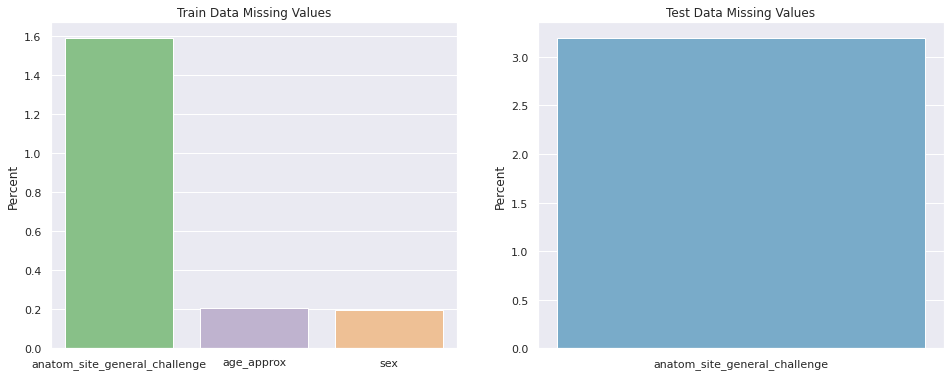

In [10]:
# Checking missing values:

def missing_percentage(df):

    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


missing_train = missing_percentage(train_data)
missing_test = missing_percentage(test_data)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=missing_train.index,
            y='Percent',
            data=missing_train,
            palette='Accent',
            ax=ax[0])

sns.barplot(x=missing_test.index,
            y='Percent',
            data=missing_test,
            palette='Blues_r',
            ax=ax[1])

ax[0].set_title('Train Data Missing Values')
ax[1].set_title('Test Data Missing Values')

## B. Names of the images <a class="anchor" id="images_names"></a>

In [11]:
train_data['image_name'].value_counts().max()

1

In [12]:
test_data['image_name'].value_counts().max()

1

The names of the images in the training and test sets are unique!

## C. Patient ID Counts <a class="anchor" id="patient_ids"></a>

In [13]:
train_data.patient_id.value_counts().min()

2

In [14]:
test_data.patient_id.value_counts().min()

3

### Insights

* Apparently, all patients have more than one image in the datasets.
* The multiple images could be either duplicates or unique images.

## D. Overlapping patients in training set and test set <a class="anchor" id="overlapping_patients"></a>

In [15]:
train_patient_ids = set(train_data.patient_id.unique())
test_patient_ids = set(test_data.patient_id.unique())

train_patient_ids.intersection(test_patient_ids)

set()

There is no overlap between the patient ids in the training set and those in the test set!

## E. Gender Counts <a class="anchor" id="gender_counts"></a>

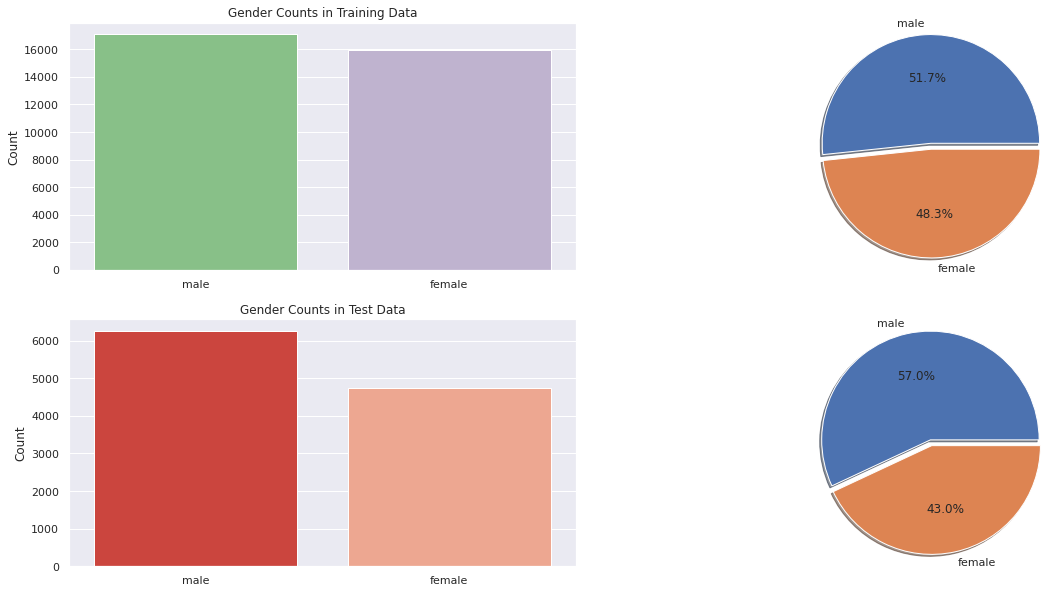

In [16]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

sns.countplot(train_data.sex, palette='Accent', ax=ax[0, 0])
ax[0, 0].set_title('Gender Counts in Training Data')
ax[0, 0].set_xlabel(' ')
ax[0, 0].set_ylabel('Count')

ax[0, 1].pie(train_data.sex.value_counts(), labels=train_data.sex.value_counts().index, 
             autopct='%1.1f%%', radius=1.1, shadow=True, explode=[0.03, 0.03])

sns.countplot(test_data.sex, palette='Reds_r', ax=ax[1, 0])
ax[1, 0].set_title('Gender Counts in Test Data')
ax[1, 0].set_xlabel(' ')
ax[1, 0].set_ylabel('Count')

ax[1, 1].pie(test_data.sex.value_counts(), labels=test_data.sex.value_counts().index, 
             autopct='%1.1f%%', radius=1.1, shadow=True, explode=[0.03, 0.03])
plt.show()

### Insights

* There are more males than females in both training and test sets.
* The surplus of males is even higher in test set than train set!

## F. Age Distribution <a class="anchor" id="age_distributions"></a>

Text(0.5, 1.0, 'Age Distribution in Test Data')

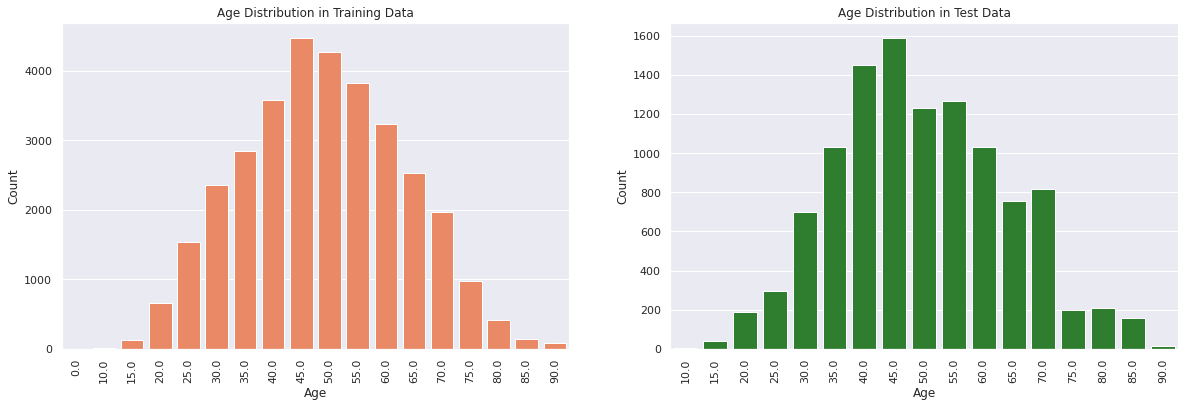

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

sns.countplot(train_data.age_approx, color='coral', ax=ax[0])
labels = ax[0].get_xticklabels()
ax[0].set_xticklabels(labels, rotation=90)
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Count')
ax[0].set_title('Age Distribution in Training Data')

sns.countplot(test_data.age_approx, color='forestgreen', ax=ax[1])
labels = ax[1].get_xticklabels()
ax[1].set_xticklabels(labels, rotation=90)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Count')
ax[1].set_title('Age Distribution in Test Data')

### Insights

* The age distribution in the training set looks almost normally distributed.
* The age distribution in the test set doesn't look normally distributed, as it has peaks at ages 55 and 70.
* There are more older patients in the test set than in the training set.

## G. Image Location <a class="anchor" id="image_location"></a>

Text(0.5, 1.0, 'Image Locations in Test Data')

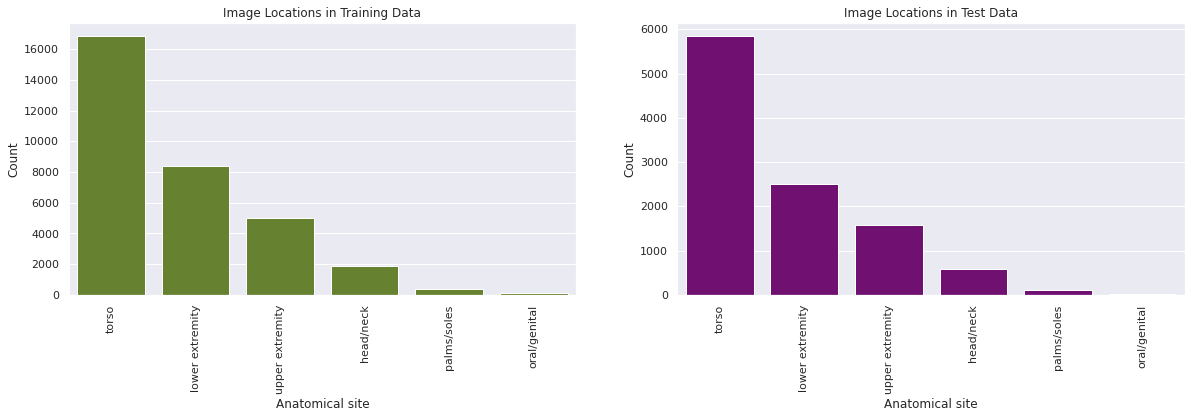

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

images_location_train = train_data.anatom_site_general_challenge.value_counts().sort_values(ascending=False)
images_location_test = test_data.anatom_site_general_challenge.value_counts().sort_values(ascending=False)

sns.barplot(x=images_location_train.index, y=images_location_train.values, color='olivedrab', ax=ax[0])
labels = ax[0].get_xticklabels()
ax[0].set_xticklabels(labels, rotation=90)
ax[0].set_xlabel('Anatomical site')
ax[0].set_ylabel('Count')
ax[0].set_title('Image Locations in Training Data')

sns.barplot(x=images_location_test.index, y=images_location_test.values, color='purple', ax=ax[1])
labels = ax[1].get_xticklabels()
ax[1].set_xticklabels(labels, rotation=90)
ax[1].set_xlabel('Anatomical site')
ax[1].set_ylabel('Count')
ax[1].set_title('Image Locations in Test Data')

### Insights

* The distribution of image location in the training set is the same as that of the test set.
* Most of the cancer images are from the torso, lower extremity and upper extremity.

## H. Target Distribution <a class="anchor" id="target_distribution"></a>

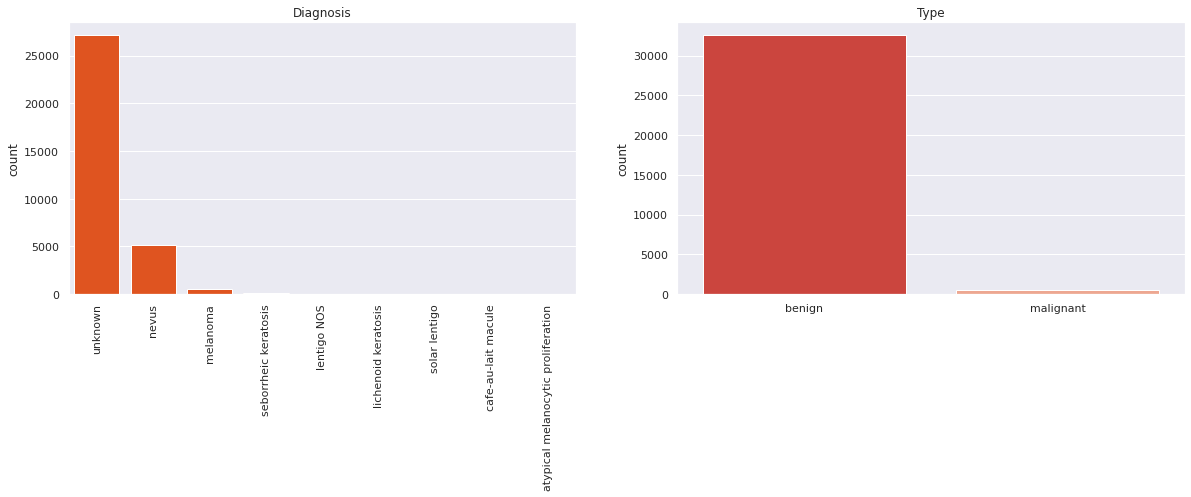

In [19]:
fig, ax = plt.subplots(1,2, figsize=(20,5))

sns.countplot(x=train_data.diagnosis, orient="v", ax=ax[0], color="Orangered")
ax[0].set_xlabel("")
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_title("Diagnosis");

sns.countplot(train_data.benign_malignant, ax=ax[1], palette="Reds_r");
ax[1].set_xlabel("")
ax[1].set_title("Type");

### Insights

* The diagnosis is often unknown, and virtually all diagnoses are benign, with malignant cases very rare.

In [20]:
train_data[train_data['benign_malignant']=='benign']['target'].nunique()

1

In [21]:
train_data[train_data['benign_malignant']=='malignant']['target'].nunique()

1

In [22]:
train_data[train_data['benign_malignant']=='benign']['target'].unique()

array([0])

In [23]:
train_data[train_data['benign_malignant']=='malignant']['target'].unique()

array([1])

In [24]:
train_data.groupby('benign_malignant')['target'].nunique()

benign_malignant
benign       1
malignant    1
Name: target, dtype: int64

The target column and the benign_malignant column are the same!
Benign in the benign_malignant feature corresponds to 0 in the target feature.
Malignant in the benign_malignant feature corresponds to 1 in the target feature.

## 4. Interaction between features <a class="anchor" id="interactions"></a>

## A. Age and Gender <a class="anchor" id="age_gender"></a>

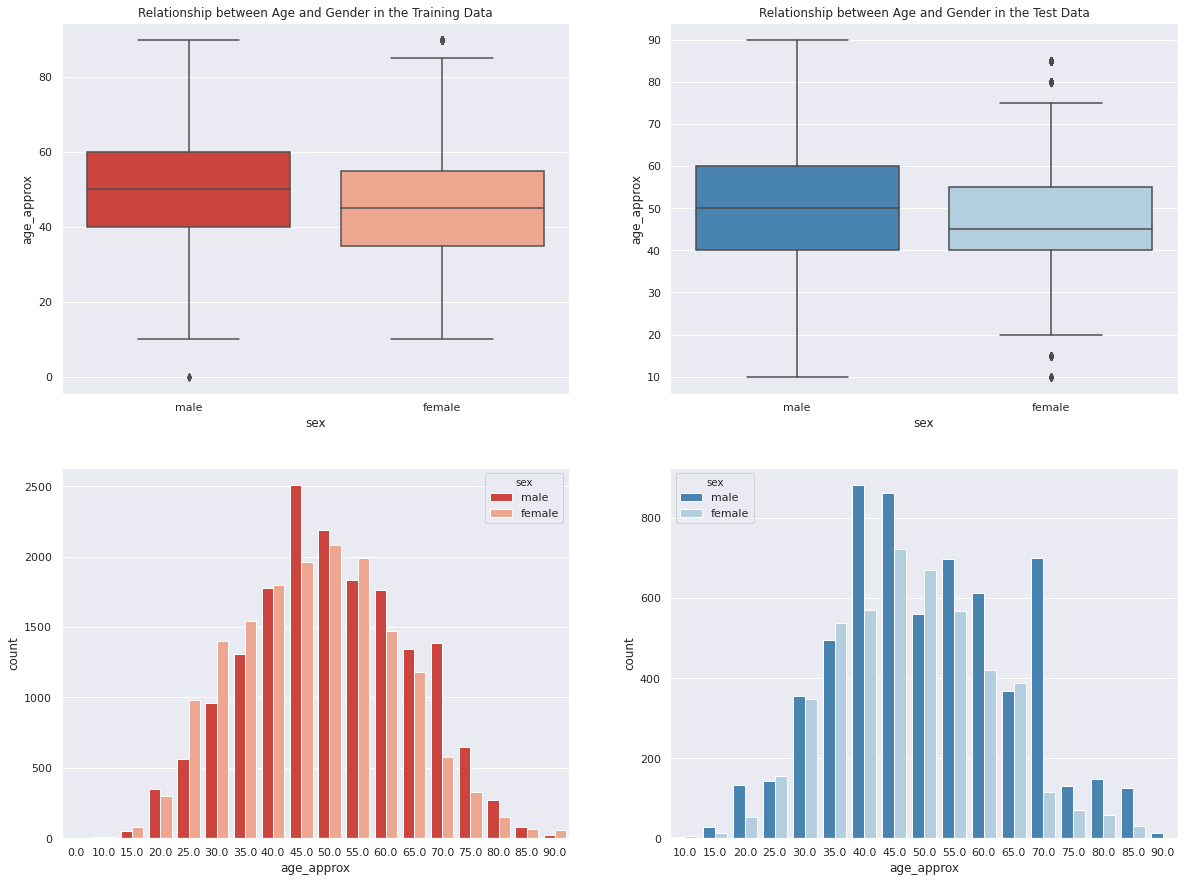

In [25]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.boxplot(train_data.sex, train_data.age_approx, ax=ax[0,0], palette="Reds_r");
ax[0,0].set_title("Relationship between Age and Gender in the Training Data");

sns.boxplot(test_data.sex, test_data.age_approx, ax=ax[0,1], palette="Blues_r");
ax[0,1].set_title("Relationship between Age and Gender in the Test Data");

sns.countplot(train_data.age_approx, hue=train_data.sex, ax=ax[1,0], palette="Reds_r");
sns.countplot(test_data.age_approx, hue=test_data.sex, ax=ax[1,1], palette="Blues_r");

### Insights

* There are much more females than males at ages below 45.
* There are more males than females at ages greater than 45; this is more obvious in the test set.

## B. Malignancy and Anatomical Site <a class="anchor" id="malignancy_anatomical_site"></a>

Text(0.5, 1.0, 'Relationship between Malignancy and Anatomical Site')

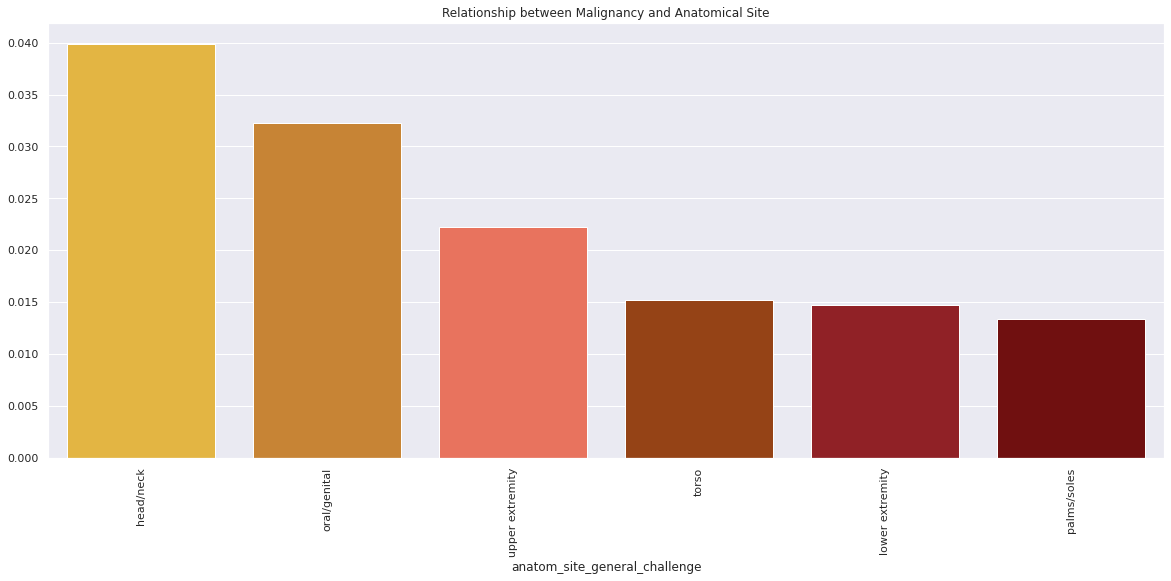

In [26]:
x = train_data.groupby('anatom_site_general_challenge').target.mean().sort_values(ascending=False)
#sns.barplot(x.index, x.values, color='olivedrab')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8))
sns.barplot(x.index, x.values, palette=['#fdc029', '#df861d', '#FF6347', '#aa3d01', '#a30e15', '#800000', '#171820'], ax=ax)
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Relationship between Malignancy and Anatomical Site')

### Insights

* Images from the head/neck are more likely to be malignant than those from other body parts.

## C. Gender and Anatomical Site <a class="anchor" id="gender_anatomical_site"></a>

Text(0.5, 1.0, 'Relationship between being Female and the Body Part that Cancer occurs')

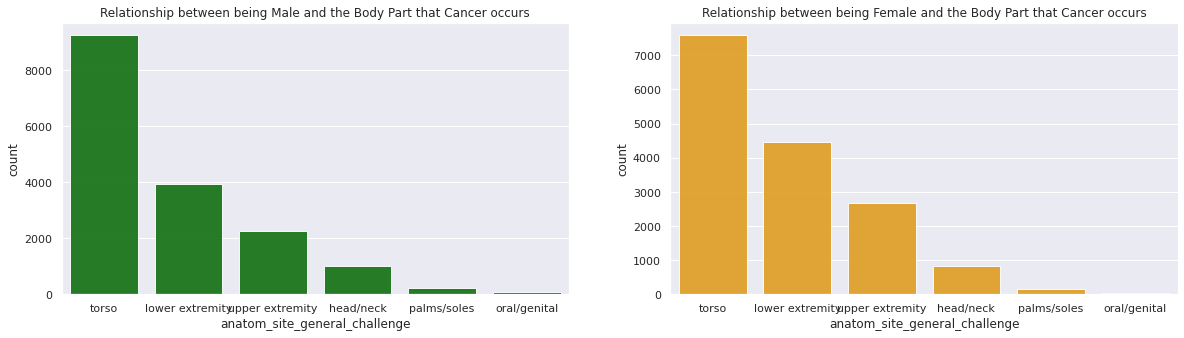

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.countplot(
    train_data[train_data['sex'] == 'male'].anatom_site_general_challenge.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax[0],
    color='green',
    label='Male',
    order=train_data['anatom_site_general_challenge'].value_counts().index
)
ax[0].set_title('Relationship between being Male and the Body Part that Cancer occurs')

sns.countplot(
    train_data[train_data['sex'] == 'female'].anatom_site_general_challenge.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax[1],
    color='orange',
    label='Male',
    order=train_data['anatom_site_general_challenge'].value_counts().index
)
ax[1].set_title('Relationship between being Female and the Body Part that Cancer occurs')

### Insights

* Both genders have equal distribution of body parts that cancer occurs.

## D. Age, Gender and Malignancy <a class="anchor" id="age_gender_malignancy"></a>

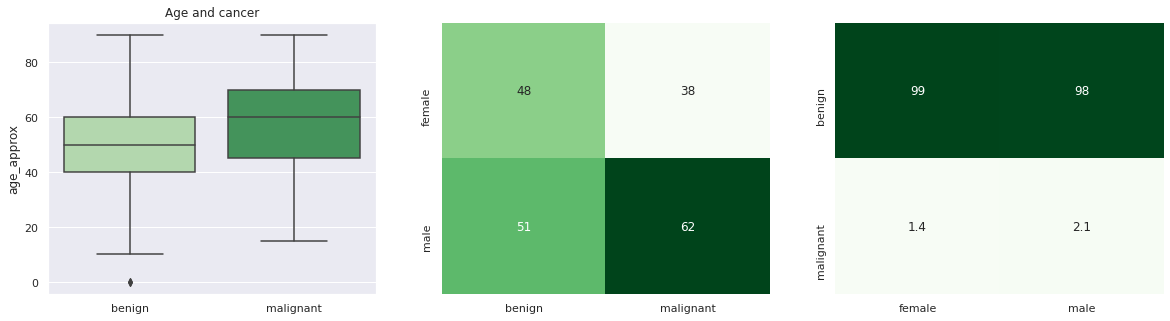

In [28]:
sex_and_cancer_map = train_data.groupby(
    ["benign_malignant", "sex"]
).size().unstack(level=0) / train_data.groupby("benign_malignant").size() * 100

cancer_sex_map = train_data.groupby(
    ["benign_malignant", "sex"]
).size().unstack(level=1) / train_data.groupby("sex").size() * 100


fig, ax = plt.subplots(1,3,figsize=(20,5))

sns.boxplot(train_data.benign_malignant, train_data.age_approx, ax=ax[0], palette="Greens");
ax[0].set_title("Age and cancer");
ax[0].set_xlabel("");

sns.heatmap(sex_and_cancer_map, annot=True, cmap="Greens", cbar=False, ax=ax[1])
ax[1].set_xlabel("")
ax[1].set_ylabel("");

sns.heatmap(cancer_sex_map, annot=True, cmap="Greens", cbar=False, ax=ax[2])
ax[2].set_xlabel("")
ax[2].set_ylabel("");

### Insights

* From the boxplot, there are more malignant cases of higher age than benign cases.
* 62% of malignant cases belong to males while 38% belong to females.
* 2.1% of males and 1.4% of females in the training set show malignancy.

Could this be that patients of a higher age are more likely to have malignant cancers?
Could this also be that sex is a factor for having skin cancer?

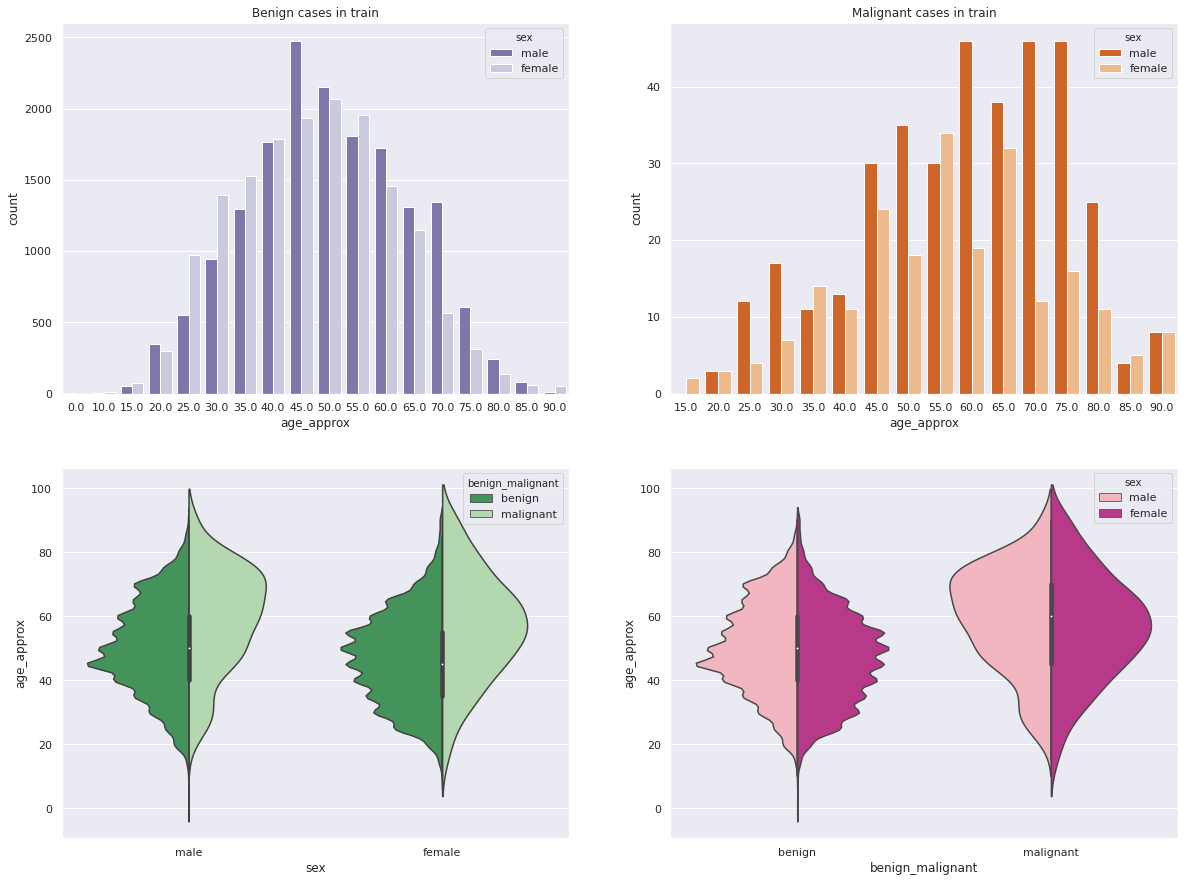

In [29]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

sns.countplot(train_data[train_data.benign_malignant=="benign"].age_approx, hue=train_data.sex, palette="Purples_r", ax=ax[0,0])
ax[0,0].set_title("Benign cases in train");

sns.countplot(train_data[train_data.benign_malignant=="malignant"].age_approx, hue=train_data.sex, palette="Oranges_r", ax=ax[0,1])
ax[0,1].set_title("Malignant cases in train");

sns.violinplot(train_data.sex, train_data.age_approx, hue=train_data.benign_malignant, split=True, ax=ax[1,0], palette="Greens_r");
sns.violinplot(train_data.benign_malignant, train_data.age_approx, hue=train_data.sex, split=True, ax=ax[1,1], palette="RdPu");

### Insights

* For the benign cases, there is a surplus of males at ages greater than 45.
* For the malignant cases, there is a high gender imbalance.

In [30]:
print(f'Number of images before duplicates were dropped: {train_data.shape[0]}')

# Drop images with tfrecord=-1 since they've been confirmed to be duplicates
train_data = train_data[train_data['tfrecord'] != -1]
print(f'Number of images after duplicates were dropped: {train_data.shape[0]}')
print(f'Features in the training set: \n {train_data.columns}')
print(f'Features in the test set: \n {test_data.columns}')

Number of images before duplicates were dropped: 33126
Number of images after duplicates were dropped: 32692
Features in the training set: 
 Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'tfrecord', 'width', 'height'],
      dtype='object')
Features in the test set: 
 Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'width', 'height'],
      dtype='object')


All features but image_name and tfrecord can be called META FEATURES since they give additional information about individual patients. These additional information may help the machine learning classifiers that are going to be built in this notebook learn the patterns in the training dataset better.

In [31]:
meta_features = [feature for feature in train_data.columns if feature not in ['image_name', 'tfrecord', 'target']]
meta_features

['patient_id',
 'sex',
 'age_approx',
 'anatom_site_general_challenge',
 'diagnosis',
 'benign_malignant',
 'width',
 'height']

## 5. View samples of the images <a class="anchor" id="view_samples"></a>

Malignant samples


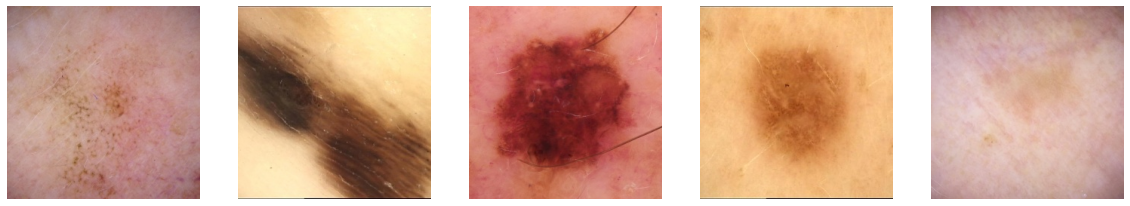

Benign samples


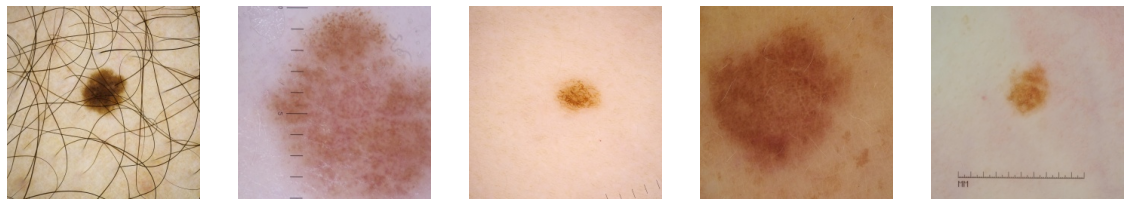

In [32]:
print('Malignant samples')
imgs = train_data.loc[train_data.target==1].sample(5).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread(DATASET_PATH + '/' + 'train/%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()
print('Benign samples')
imgs = train_data.loc[train_data.target==0].sample(5).image_name.values
plt.figure(figsize=(20,8))
for i,k in enumerate(imgs):
    img = cv2.imread(DATASET_PATH + '/' + 'train/%s.jpg'%k)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.subplot(2,5,i+1); plt.axis('off')
    plt.imshow(img)
plt.show()

## 6. Switch to TFRecords

The training and test set TFRecords contain both the image data and tabular data (meta data). They are triple stratified and leak free.

The training tfrecords have fields image, image_name, patient_id, sex, age_approx, anatom_site_general_challenge, diagnosis, target, width, height.

The missing values in age_approx have been imputed to mean.
<br> The missing values in sex and anatom_site_general_challenge have been imputed to 'unknown'.
<br>anatom_site_general_challenge and diagnosis have both been label encoded.

In [33]:
GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-256x256')
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

## A. Set the configuration values <a class="anchor" id="configuration_vals"></a>

In [34]:
config = dict(
    DEVICE = 'TPU',
    SEED = 42,
    N_FOLDS = 3,
    BATCH_SIZE = 32,

    READ_SIZE = 256,
    CROP_SIZE = 250,
    NET_SIZE = 224,

    ROT_ = 180.0,
    SHR_ = 2.0,
    HZOOM_ = 8.0,
    WZOOM_ = 8.0,
    HSHIFT_ = 8.0,
    WSHIFT_ = 8.0,
    
    LR_START = 0.000005,
    LR_MAX = 0.000020,
    LR_MIN = 0.000001,
    LR_RAMPUP_EPOCHS = 5,
    LR_SUSTAIN_EPOCHS = 0,
    LR_EXP_DECAY = 0.8,
    NUM_EPOCHS = 15,
    
    TTA_STEPS = 10
)

In [35]:
if config['DEVICE'] == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if config['DEVICE'] != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if config['DEVICE'] == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    
    
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


## B. Augmentations <a class="anchor" id="augmentations"></a>

In [36]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, config):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = config["READ_SIZE"]
    XDIM = DIM%2 #fix for size 331
    
    rot = config['ROT_'] * tf.random.normal([1], dtype='float32')
    shr = config['SHR_'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / config['HZOOM_']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / config['WZOOM_']
    h_shift = config['HSHIFT_'] * tf.random.normal([1], dtype='float32') 
    w_shift = config['WSHIFT_'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

## C. Parse the features of the TFRecord <a class="anchor" id="parse_features"></a>

In [37]:
def parse_features(example, max_age):
    # image data
    image = example['image']
    data = {}
    # bytestring features
    data['image_name'] = tf.cast(example['image_name'], tf.string)
    data['patient_id'] = tf.cast(example['patient_id'], tf.int64)
    # integer features
    #-----sex
    sex_dump = {}
    sex_dump['sex'] = tf.cast(tf.one_hot(example['sex'], 3), tf.int32)
    for i in range(3):
        data[f'sex_{i}'] = sex_dump['sex'][i]
    
    #----anatomical site
    anatomical_site_dump = {}
    anatomical_site_dump['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    for i in range(7):
        data[f'anatom_site_general_challenge_{i}'] = anatomical_site_dump['anatom_site_general_challenge'][i]
    
    #------age
    data['age_approx'] = tf.cast(example['age_approx'], tf.float32) / max_age
    
    return image, data 

## D. Read the TFRecord <a class="anchor" id="read_tfrecord"></a>

In [38]:
def read_labeled_tfrecord(example):
    LABELED_TFRECORD_FORMAT = {
        
        # bytestring features
        'image' : tf.io.FixedLenFeature([], tf.string),
        'image_name' : tf.io.FixedLenFeature([], tf.string),
        'patient_id' : tf.io.FixedLenFeature([], tf.int64),
        # integer features
        'sex' : tf.io.FixedLenFeature([], tf.int64),
        'age_approx' : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge' : tf.io.FixedLenFeature([], tf.int64),
        'target' : tf.io.FixedLenFeature([], tf.int64)
        
    }
    example = tf.io.parse_single_example(example, LABELED_TFRECORD_FORMAT)
    image, data = parse_features(example, max_age=train_data['age_approx'].max())
    
    return image, data, example['target']

def read_unlabeled_tfrecord(example):
    UNLABELED_TFRECORD_FORMAT = {
        
        # bytestring features
        'image' : tf.io.FixedLenFeature([], tf.string),
        'image_name' : tf.io.FixedLenFeature([], tf.string),
        'patient_id' : tf.io.FixedLenFeature([], tf.int64),
        # integer features
        'sex' : tf.io.FixedLenFeature([], tf.int64),
        'age_approx' : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge' : tf.io.FixedLenFeature([], tf.int64),
        
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFRECORD_FORMAT)
    image, data = parse_features(example, max_age=train_data['age_approx'].max())
    
    return image, data, example['image_name']

## E. Prepare the images and the meta features <a class="anchor" id="prepare"></a>

In [39]:
def prepare_images(img, config=None, augment=True):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [config['READ_SIZE'], config['READ_SIZE']])
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img, config)
        img = tf.image.random_crop(img, [config['CROP_SIZE'], config['CROP_SIZE'], 3])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)

    else:
        img = tf.image.central_crop(img, config['CROP_SIZE'] / config['CROP_SIZE']) #------------
                                   
    img = tf.image.resize(img, [config['NET_SIZE'], config['NET_SIZE']])
    img = tf.reshape(img, [config['NET_SIZE'], config['NET_SIZE'], 3])
    return img

In [40]:
meta_features = [
    'sex_0', 'sex_1', 'sex_2', 'anatom_site_general_challenge_0', 'anatom_site_general_challenge_1', 
    'anatom_site_general_challenge_2', 'anatom_site_general_challenge_3', 'anatom_site_general_challenge_4', 
    'anatom_site_general_challenge_5', 'anatom_site_general_challenge_6', 'age_approx'
]

def prepare_features(data, meta_features):
    meta_data = [tf.cast(data[tfeat], dtype=tf.float32) for tfeat in meta_features]
    
    tabular = tf.stack(meta_data)
    return tabular

In [41]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## F. Build a dataset generator <a class="anchor" id="get_dataset"></a>

In [42]:
def get_dataset(files, config, augment = False, shuffle = False, repeat = False, 
                labeled=True):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, data, label: (prepare_images(img, 
                                                        augment=augment,
                                                        config=config), 
                                          prepare_features(data, meta_features), label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(config['BATCH_SIZE'] * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

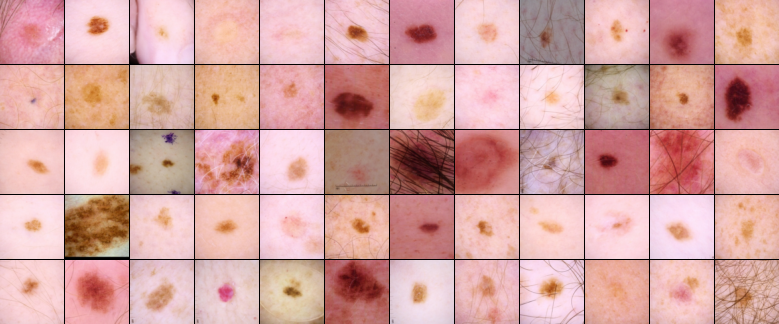

In [43]:
def show_dataset(thumb_size, cols, rows, ds):
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, data, label = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)
    
ds = get_dataset(files_train, config=config).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

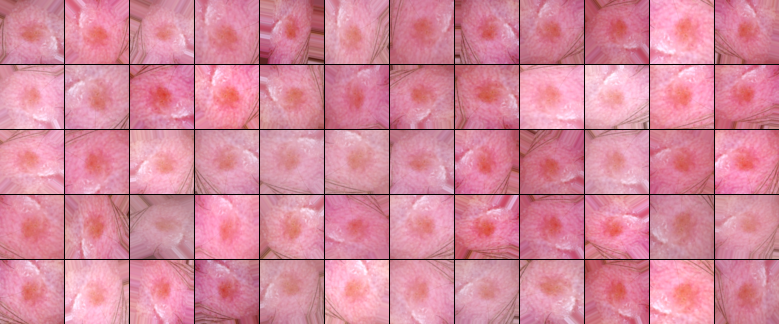

In [44]:
ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
ds = ds.take(1).cache().repeat()
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda img, data, target: (prepare_images(img, config=config, augment=True), data, target), 
            num_parallel_calls=AUTO)
ds = ds.take(12*5)
ds = ds.prefetch(AUTO)

show_dataset(64, 12, 5, ds)

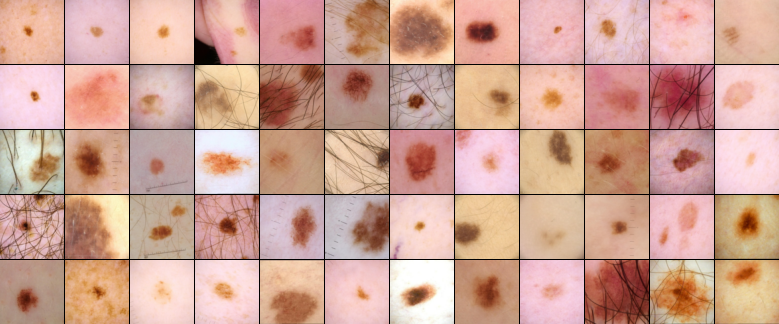

In [45]:
ds = get_dataset(files_test, config=config, labeled=False).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

## G. Loss and Evaluation

Since the dataset is binary and highly imbalanced, there are a wide variety of loss functions I can pick from. Focal loss and Weighted binary crossentropy loss are two of these loss functions.

### Cross entropy loss


$$L_{bce} = - \sum_{n}^{N} \sum_{k}^{2} t_{n,k} \cdot \log(y_{n,k}) = \sum_{n}^{N} \cdot l_{bce}$$

$$l_{bce} = - \sum_{k}^{2} t_{n,k} \cdot \log(y_{n,k}) $$

Since the frequency of malignant cases is way lesser than that of benign cases, perform BALANCED CLASS WEIGHTING such that malignant cases are given a higher weight than benign cases during model training.

In [46]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(train_data['target'].values), 
    y=train_data['target'].values
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}
#class_weights = tf.cast([weight for label, weight in class_weights.items()], tf.float64)
print(class_weights)

{0: 0.509046744106381, 1: 28.134251290877796}


Evaluation of the machine learning classifier will be based on the Area Under the Reciever Operating Characteristics Curve (AUC).

## H. Define the Learning Rate <a class="anchor" id="define_lr"></a>

In [47]:
lr_start   = config['LR_START']
lr_max     = config['LR_MAX'] * strategy.num_replicas_in_sync
lr_min     = config['LR_MIN']
lr_ramp_ep = config['LR_RAMPUP_EPOCHS']
lr_sus_ep  = config['LR_SUSTAIN_EPOCHS']
lr_decay   = config['LR_EXP_DECAY']

def lrfn(epoch):
    if epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max
            
    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
    return lr

In [48]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)

Learning rate schedule: 5e-06 to 0.00016 to 2.23e-05


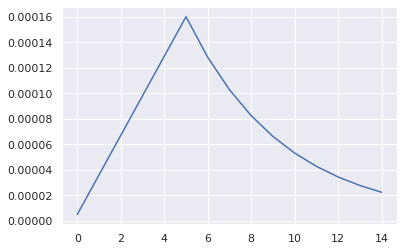

In [49]:
rng = [i for i in range(config['NUM_EPOCHS'])]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## I. Neural Network Architecture <a class="anchor" id="model"></a>

In [50]:
def build_model():
    efficientNet = efn.EfficientNetB6(
        weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = tf.keras.layers.GlobalAveragePooling2D()(efficientNet.output)

    cnn_model = tf.keras.models.Model(inputs=efficientNet.inputs, outputs=x)

    mlp_input = tf.keras.layers.Input(shape=len(meta_features), name='mlp_input')
    fc_layer_1 = tf.keras.layers.Dense(256)(mlp_input)
    batch_norm_1 = tf.keras.layers.BatchNormalization(axis=-1)(fc_layer_1)
    activation_1 = tf.keras.layers.Activation('relu')(batch_norm_1)
    dropout_1 = tf.keras.layers.Dropout(0.3)(activation_1)

    fc_layer_2 = tf.keras.layers.Dense(256)(dropout_1)
    batch_norm_2 = tf.keras.layers.BatchNormalization(axis=-1)(fc_layer_2)
    activation_2 = tf.keras.layers.Activation('relu')(batch_norm_2)
    dropout_2 = tf.keras.layers.Dropout(0.3)(activation_2)

    multi_layer_perceptron = tf.keras.models.Model(inputs=mlp_input, outputs=dropout_2)

    combinedInput = tf.keras.layers.concatenate([cnn_model.output, multi_layer_perceptron.output])
    output = tf.keras.layers.Dense(1, activation='sigmoid')(combinedInput)
    model = tf.keras.models.Model(inputs=[cnn_model.input, multi_layer_perceptron.input], outputs=output)

    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05) 
    model.compile(optimizer=opt,loss=loss,metrics=[tf.keras.metrics.AUC(name='auc')])
    return model

## J. Training Loop <a class="anchor" id="train_loop"></a>

****Fold 1
165527552/165527152 [==============================] - 6s 0us/step
Training...
Epoch 1/15
86/85 [==============================] - ETA: 0s - auc: 0.5536 - loss: 0.7089
Epoch 00001: val_loss improved from inf to 0.77336, saving model to fold-1.h5
86/85 [==============================] - 66s 771ms/step - auc: 0.5536 - loss: 0.7089 - val_auc: 0.3917 - val_loss: 0.7734 - lr: 5.0000e-06
Epoch 2/15
86/85 [==============================] - ETA: 0s - auc: 0.6805 - loss: 0.6554
Epoch 00002: val_loss improved from 0.77336 to 0.58645, saving model to fold-1.h5
86/85 [==============================] - 38s 443ms/step - auc: 0.6805 - loss: 0.6554 - val_auc: 0.6532 - val_loss: 0.5864 - lr: 3.6000e-05
Epoch 3/15
86/85 [==============================] - ETA: 0s - auc: 0.8000 - loss: 0.5719
Epoch 00003: val_loss improved from 0.58645 to 0.43671, saving model to fold-1.h5
86/85 [==============================] - 39s 448ms/step - auc: 0.8000 - loss: 0.5719 - val_auc: 0.8018 - val_loss: 0.4367 -

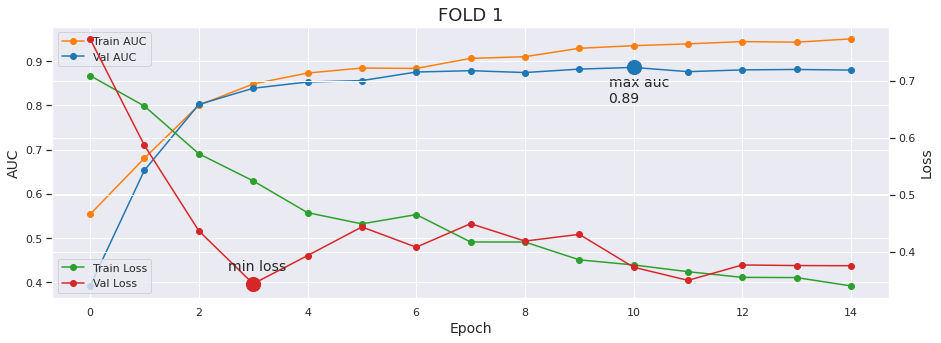

****Fold 2
Training...
Epoch 1/15
86/85 [==============================] - ETA: 0s - auc: 0.5098 - loss: 0.7448
Epoch 00001: val_loss improved from inf to 0.49353, saving model to fold-2.h5
86/85 [==============================] - 67s 774ms/step - auc: 0.5098 - loss: 0.7448 - val_auc: 0.6271 - val_loss: 0.4935 - lr: 5.0000e-06
Epoch 2/15
86/85 [==============================] - ETA: 0s - auc: 0.6550 - loss: 0.6626
Epoch 00002: val_loss improved from 0.49353 to 0.46320, saving model to fold-2.h5
86/85 [==============================] - 39s 458ms/step - auc: 0.6550 - loss: 0.6626 - val_auc: 0.7411 - val_loss: 0.4632 - lr: 3.6000e-05
Epoch 3/15
86/85 [==============================] - ETA: 0s - auc: 0.8064 - loss: 0.5700
Epoch 00003: val_loss improved from 0.46320 to 0.39836, saving model to fold-2.h5
86/85 [==============================] - 39s 456ms/step - auc: 0.8064 - loss: 0.5700 - val_auc: 0.8271 - val_loss: 0.3984 - lr: 6.7000e-05
Epoch 4/15
86/85 [==============================] -

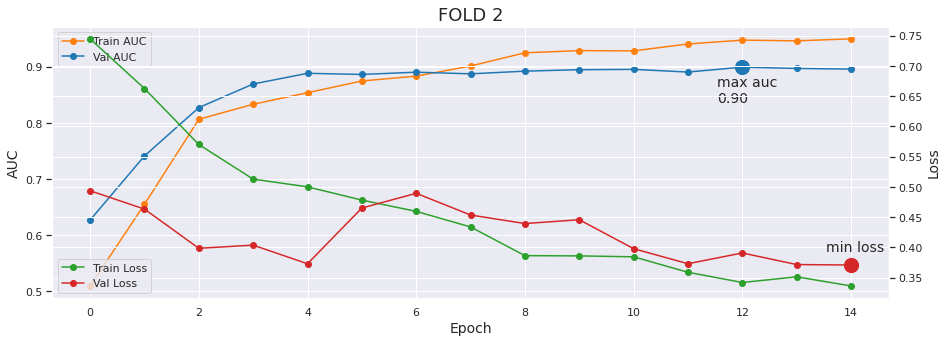

****Fold 3
Training...
Epoch 1/15
86/85 [==============================] - ETA: 0s - auc: 0.5272 - loss: 0.7096
Epoch 00001: val_loss improved from inf to 0.62954, saving model to fold-3.h5
86/85 [==============================] - 65s 761ms/step - auc: 0.5272 - loss: 0.7096 - val_auc: 0.6414 - val_loss: 0.6295 - lr: 5.0000e-06
Epoch 2/15
86/85 [==============================] - ETA: 0s - auc: 0.6792 - loss: 0.6501
Epoch 00002: val_loss improved from 0.62954 to 0.51729, saving model to fold-3.h5
86/85 [==============================] - 38s 445ms/step - auc: 0.6792 - loss: 0.6501 - val_auc: 0.7478 - val_loss: 0.5173 - lr: 3.6000e-05
Epoch 3/15
86/85 [==============================] - ETA: 0s - auc: 0.7925 - loss: 0.5698
Epoch 00003: val_loss improved from 0.51729 to 0.40931, saving model to fold-3.h5
86/85 [==============================] - 38s 439ms/step - auc: 0.7925 - loss: 0.5698 - val_auc: 0.8420 - val_loss: 0.4093 - lr: 6.7000e-05
Epoch 4/15
86/85 [==============================] -

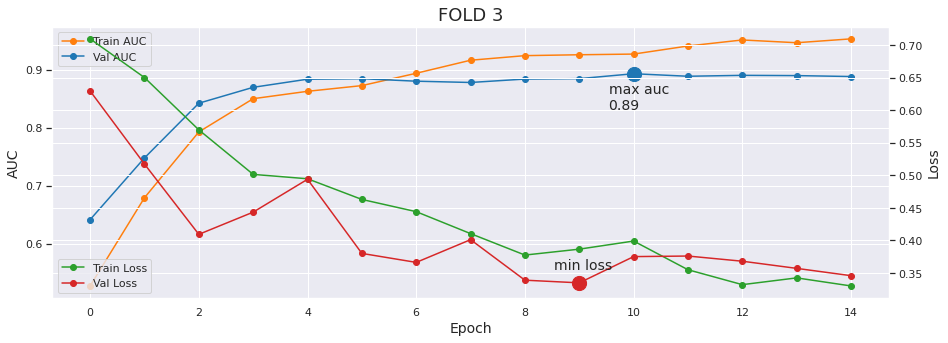

In [51]:
VERBOSE = 1
DISPLAY_PLOT = True

kfold = KFold(n_splits=config['N_FOLDS'], shuffle=True, random_state=config['SEED'])
oof_preds, oof_labels, oof_names = [], [], []
test_preds = np.zeros((count_data_items(files_test),1))

for fold, (train_idxs, test_idxs) in enumerate(kfold.split(np.arange(15))):
    print('****Fold {}'.format(fold+1))
    training_files = np.sort(np.array(tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in train_idxs])))
    validation_files = np.sort(np.array(tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in test_idxs])))
    testing_files  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    
    ds_train = get_dataset(training_files, config, augment=True, shuffle=True, repeat=True)
    ds_val = get_dataset(validation_files, config, augment=False, shuffle=False, repeat=False)
    
    ds_train = ds_train.map(lambda img, data, label: ((img, data), (label)))
    ds_val = ds_val.map(lambda img, data, label: ((img, data), (label)))
    
    # Save the best model of each fold
    modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(
        'fold-{}.h5'.format(fold+1), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='min', save_freq='epoch'
    )
    
    # Compile the model
    with strategy.scope():
        model = build_model()
    
    print('Training...')
    H = model.fit(
        ds_train, steps_per_epoch = count_data_items(training_files)/(config['BATCH_SIZE']*REPLICAS), 
        validation_data = ds_val, epochs=config['NUM_EPOCHS'], callbacks=[lr_callback, modelCheckpoint], 
        verbose=VERBOSE, class_weight=class_weights
        )
    
    print('Loading the best model...')
    model.load_weights('fold-{}.h5'.format(fold+1))
    
    print('Predicting OOF with TTA...')
    ds_val = get_dataset(validation_files, config, augment=True, shuffle=False, repeat=True, labeled=False)
    ds_val = ds_val.map(lambda img, data, label: ((img, data),))
    steps = count_data_items(validation_files)/(config['BATCH_SIZE']*REPLICAS) * config['TTA_STEPS']
    probs = model.predict(ds_val, verbose=1, steps=steps)[:config['TTA_STEPS']*count_data_items(validation_files),] 
    oof_preds.append(np.mean(probs.reshape((count_data_items(validation_files),config['TTA_STEPS']),order='F'),axis=1))
    
    # Get OOF labels and names
    ds_val = get_dataset(validation_files, config, augment=False, shuffle=False, repeat=False, labeled=True)
    oof_labels.append(np.array([target.numpy() for img, data, target in iter(ds_val.unbatch())]) )
    ds_val = get_dataset(validation_files, config, augment=False, shuffle=False, repeat=False, labeled=False)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") 
                        for img, data, img_name in iter(ds_val.unbatch())]))
    
    print('Predicting on the test data with TTA...')
    ds_test = get_dataset(testing_files, config, augment=True, shuffle=False, repeat=True, labeled=False)
    ds_test = ds_test.map(lambda img, data, img_name: ((img, data),))
    steps = count_data_items(testing_files)/(config['BATCH_SIZE']*REPLICAS) * config['TTA_STEPS']
    probs = model.predict(ds_test, verbose=1, steps=steps)[:config['TTA_STEPS']*count_data_items(testing_files),] 
    probs = np.mean(probs.reshape((count_data_items(testing_files),config['TTA_STEPS']),order='F'),axis=1)
    test_preds[:, 0] += probs*(1/config['N_FOLDS'])
    
    #Report results
    oof_tta_auc = roc_auc_score(oof_labels[-1], oof_preds[-1])
    oof_auc = np.max(H.history['val_auc'])
    print('****FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_auc, oof_tta_auc))
    
    # Display the graphs for this fold
    if DISPLAY_PLOT:
        plt.figure(figsize=(15,5))
        plt.plot(np.arange(config['NUM_EPOCHS']),H.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
        plt.plot(np.arange(config['NUM_EPOCHS']),H.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
        x = np.argmax( H.history['val_auc'] ); y = np.max( H.history['val_auc'] )
        xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
        plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
        plt.legend(loc=2)
        plt2 = plt.gca().twinx()
        plt2.plot(np.arange(config['NUM_EPOCHS']),H.history['loss'],'-o',label='Train Loss',color='#2ca02c')
        plt2.plot(np.arange(config['NUM_EPOCHS']),H.history['val_loss'],'-o',label='Val Loss',color='#d62728')
        x = np.argmin( H.history['val_loss'] ); y = np.min( H.history['val_loss'] )
        ydist = plt.ylim()[1] - plt.ylim()[0]
        plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
        plt.ylabel('Loss',size=14)
        plt.title('FOLD %i'%
                (fold+1),size=18)
        plt.legend(loc=3)
        plt.show()    

## K. Get OFF Score <a class="anchor" id="oof_score"></a>

In [53]:
# Compute the overall OOF AUC
oof_labels = np.concatenate(oof_labels)
oof_preds = np.concatenate(oof_preds)

print('Overall OOF AUC with TTA: {}'.format(roc_auc_score(oof_labels, oof_preds)))


# This block of code is responsible for the ValueError below
oof_names = np.concatenate(oof_labels)
df_oof = pd.DataFrame({'image_name' : oof_names, 'target' : oof_labels, 'pred' : oof_preds})
df_oof.to_csv('oof_csv', index=False)
df_oof.head()

Overall OOF AUC with TTA: 0.88930981179687


ValueError: zero-dimensional arrays cannot be concatenated

## 7. Conclusion <a class="anchor" id="conclusion"></a>

Melanoma is a deadly disease, but if caught early, most melanomas can be cured with minor surgery. Image analysis tools that automate the diagnosis of melanoma will improve dermatologists' diagnostic accuracy. Better detection of melanoma has the opportunity to positively impact millions of people.